Para saber:
- Este modelo de red neuronal cuenta con "capas densas", porque cada neurona de una capa se conecta con todas las neuronas de la capa siguiente.
- Es una "red profunda" ya que esta utilizando >1 capa oculta.
- Al entrenar con imagenes de las cuales ya sabemos la respuesta correcta estamos haciendo "aprendizaje supervisado".
- Realizamos "entrenamiento por lotes", ya que estamos utilizando lotes de entrenamiento(batch). Despues de cada lote se mide el error de la función de costo y el optimizador ajusta los pesos y umbrales buscando minimizar esa función y lograr tener una red que pueda entender lo que le estamos mostrando.


In [1]:
# Importamos las librerias necesarias:
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
# Descargamos el set de datos Fashion MNIST de Zalando, con sus metadatos:
datos, metadatos = tfds.load('fashion_mnist', as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/fashion_mnist/3.0.1.incompleteVWL9IG/fashion_mnist-train.tfrecord*...:   0%|  …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/fashion_mnist/3.0.1.incompleteVWL9IG/fashion_mnist-test.tfrecord*...:   0%|   …

Dataset fashion_mnist downloaded and prepared to ~/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [3]:
# Visualizamos la info de los metadatos descargados:
metadatos

tfds.core.DatasetInfo(
    name='fashion_mnist',
    full_name='fashion_mnist/3.0.1',
    description="""
    Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.
    """,
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    data_path='~/tensorflow_datasets/fashion_mnist/3.0.1',
    file_format=tfrecord,
    download_size=29.45 MiB,
    dataset_size=36.42 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
      author  

In [4]:
# Ponemos cada conjunto de datos en variables diferentes para poder utilizarlos:
datos_entrenamiento, datos_pruebas = datos['train'], datos['test']

In [5]:
# Los metadatos traen ademas los nombres de las categorias que existen en el set.
# Les asignamos una variable asi los podemos imprimir:
nombres_clases = metadatos.features['label'].names

In [6]:
# Estas son las categorias y podemos ver que el indice 0 es "T-shirt/top",
# el indice 1 es "Trouser" y asi hasta el indice 9 que es "Ankle boot".
nombres_clases

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [7]:
# Debemos normalizar los datos: pasar de 0-255 a 0-1:
def normalizar(imagenes, etiquetas):
  imagenes = tf.cast(imagenes, tf.float32)
  imagenes /= 255 # Aqui lo pasa de 0-255 a 0-1
  return imagenes, etiquetas

# Normalizar los datos de entrenamiento y pruebas con la funcion que hicimos:
datos_entrenamiento = datos_entrenamiento.map(normalizar)
datos_pruebas = datos_pruebas.map(normalizar)

# Agregamos los datos a cache (usa la ram en vez de disco y es mas rapido):
datos_entrenamiento = datos_entrenamiento.cache()
datos_pruebas = datos_pruebas.cache()

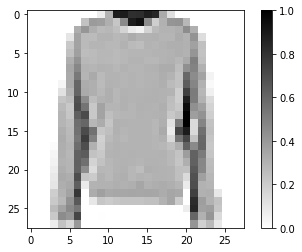

In [8]:
# Mostrar una imagen de los datos de prueba, de momento mostraremos la primera:
for imagen, etiqueta in datos_entrenamiento.take(1):
  break
imagen = imagen.numpy().reshape((28,28)) # Redimensionamos

import matplotlib.pyplot as plt

# Dibujamos:
plt.figure()
plt.imshow(imagen, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

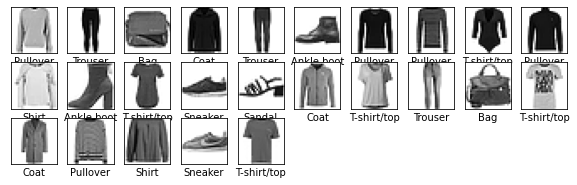

In [9]:
# Podemos imprimir cualquier imagen y que nos diga la categoria correcta con que
# viene etiquetada:
plt.figure(figsize=(10,10))
for i, (imagen, etiqueta) in enumerate(datos_entrenamiento.take(25)): # Cantidad de imagenes
  imagen = imagen.numpy().reshape((28,28))
  plt.subplot(10,10,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(imagen, cmap=plt.cm.binary)
  plt.xlabel(nombres_clases[etiqueta])
plt.show()

In [10]:
# Ahora creamos el modelo con una red del tipo Sequential y función de activación 
# ReLu (Rectifier Linear Unit  y consiste en f(x)=max(0,x).: 
modelo = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(28,28,1)),     # 1 canal = Blanco y Negro y 3 canales es color (rgb).
  tf.keras.layers.Dense(192, activation=tf.nn.relu),  # Capa oculta densa con 192 neuronas. 
  tf.keras.layers.Dense(192, activation=tf.nn.relu),  # Capa oculta densa con 192 neuronas.
  tf.keras.layers.Dense(192, activation=tf.nn.relu),  # Capa oculta densa con 192 neuronas.
  tf.keras.layers.Dense(192, activation=tf.nn.relu),  # Capa oculta densa con 192 neuronas.
  tf.keras.layers.Dense(10, activation=tf.nn.softmax) # Capa de salida con funcion de activacion
                                                      # "softmax" (se usa en capa de salida en redes de 
                                                      # clasificacion).
])

In [11]:
# Compilamos el modelo:
modelo.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics = ['accuracy']
)

In [12]:
# Definimos 2 variables para tener el nro de ejemplos de entrenamiento y prueba:
num_ej_entrenamiento = metadatos.splits["train"].num_examples
num_ej_pruebas = metadatos.splits["test"].num_examples

In [13]:
# Las imprimimos:
print(num_ej_entrenamiento)
print(num_ej_pruebas)

60000
10000


In [14]:
# Haremos que entrene en lotes. Definimos un tamaño de lote de 48 y ajustaremos 
# algunas propiedades de los datos de entrenamiento y prueba. Como daremos vs 
# vueltas al set de datos en el entrenamiento queremos que se haga de manera 
# aleatoria y no siempre en un mismo orden, para eso usaremos 2 funciones: 
# "repeat" y "shuffle" con lo cual el orden de los datos sera aleatorio y con
# "batch" definimos el tamaño del lote de entrenamiento. El trabajo por lotes
# permite que entrenamientos con gran cantidad de datos se haga de manera mas
# eficiente:
TAMAÑO_LOTE = 48

datos_entrenamiento = datos_entrenamiento.repeat().shuffle(num_ej_entrenamiento).batch(TAMAÑO_LOTE)
datos_pruebas = datos_pruebas.batch(TAMAÑO_LOTE) # solo usamos batch

In [15]:
# Para entrenar el modelo usamos "fit", especificamos los datos de entrenamiento 
# y cuantas vueltas queremos darle a los datos:
import math
historial = modelo.fit(datos_entrenamiento, epochs=50, steps_per_epoch= math.ceil(num_ej_entrenamiento/TAMAÑO_LOTE))


Epoch 1/50
1250/1250 [==============================] - 11s 3ms/step - loss: 0.4881 - accuracy: 0.8251
Epoch 2/50
1250/1250 [==============================] - 4s 3ms/step - loss: 0.3663 - accuracy: 0.8655
Epoch 3/50
1250/1250 [==============================] - 4s 3ms/step - loss: 0.3263 - accuracy: 0.8796
Epoch 4/50
1250/1250 [==============================] - 4s 3ms/step - loss: 0.3104 - accuracy: 0.8845
Epoch 5/50
1250/1250 [==============================] - 4s 3ms/step - loss: 0.2884 - accuracy: 0.8931
Epoch 6/50
1250/1250 [==============================] - 4s 3ms/step - loss: 0.2752 - accuracy: 0.8968
Epoch 7/50
1250/1250 [==============================] - 4s 3ms/step - loss: 0.2654 - accuracy: 0.9004
Epoch 8/50
1250/1250 [==============================] - 4s 3ms/step - loss: 0.2542 - accuracy: 0.9048
Epoch 9/50
1250/1250 [==============================] - 4s 3ms/step - loss: 0.2429 - accuracy: 0.9079
Epoch 10/50
1250/1250 [==============================] - 4s 3ms/step - loss: 0.23

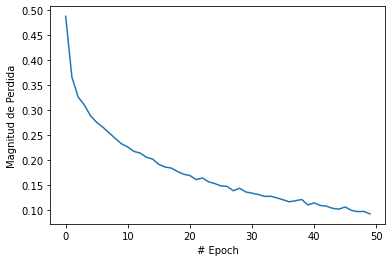

In [16]:
# Veamos el resultado de la funcion de perdida en cada epoca:
plt.xlabel("# Epoch")
plt.ylabel("Magnitud de Perdida")
plt.plot(historial.history["loss"])

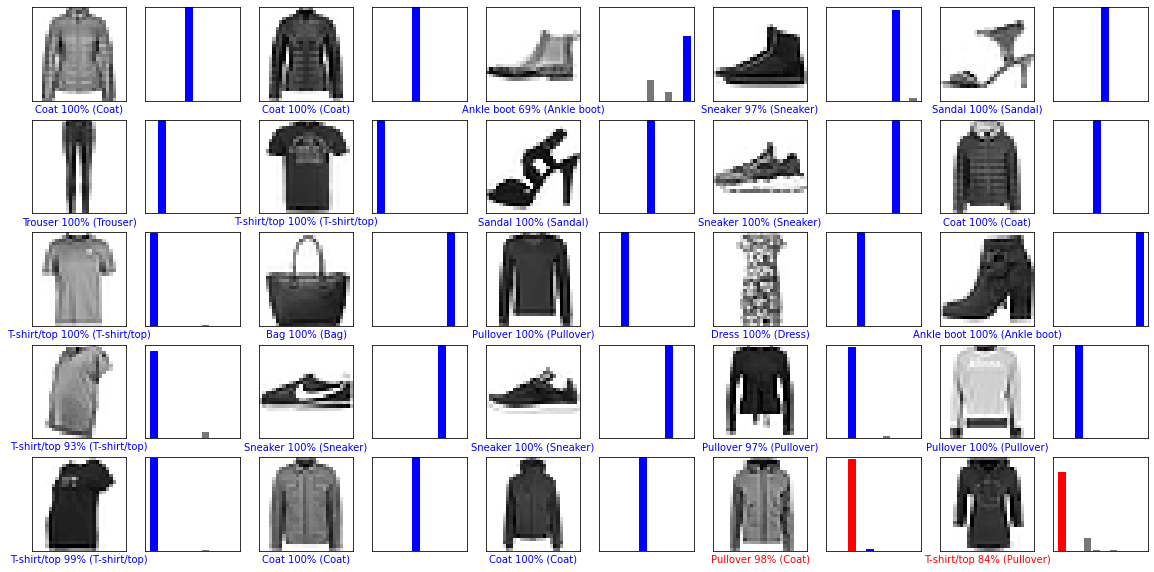

In [17]:
# Este código no es de IA sino de matplotlib y es para imprimir un set de 25
# imagenes del set de pruebas y que intente predecir c/u, pintando una cuadricula
# con vs predicciones, y marcar si fue correcta (azul) o incorrecta (roja):
import numpy as np

for imagenes_prueba, etiquetas_prueba in datos_pruebas.take(1):
  imagenes_prueba = imagenes_prueba.numpy()
  etiquetas_prueba = etiquetas_prueba.numpy()
  predicciones = modelo.predict(imagenes_prueba)
  
def graficar_imagen(i, arr_predicciones, etiquetas_reales, imagenes):
  arr_predicciones, etiqueta_real, img = arr_predicciones[i], etiquetas_reales[i], imagenes[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)

  etiqueta_prediccion = np.argmax(arr_predicciones)
  if etiqueta_prediccion == etiqueta_real:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(nombres_clases[etiqueta_prediccion],
                                100*np.max(arr_predicciones),
                                nombres_clases[etiqueta_real]),
                                color=color)
  
def graficar_valor_arreglo(i, arr_predicciones, etiqueta_real):
  arr_predicciones, etiqueta_real = arr_predicciones[i], etiqueta_real[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  grafica = plt.bar(range(10), arr_predicciones, color="#777777")
  plt.ylim([0, 1]) 
  etiqueta_prediccion = np.argmax(arr_predicciones)
  
  grafica[etiqueta_prediccion].set_color('red')
  grafica[etiqueta_real].set_color('blue')
  
filas = 5
columnas = 5
num_imagenes = filas*columnas
plt.figure(figsize=(2*2*columnas, 2*filas))
for i in range(num_imagenes):
  plt.subplot(filas, 2*columnas, 2*i+1)
  graficar_imagen(i, predicciones, etiquetas_prueba, imagenes_prueba)
  plt.subplot(filas, 2*columnas, 2*i+2)
  graficar_valor_arreglo(i, predicciones, etiquetas_prueba)
                              

In [18]:
# Con esto podemos probar una imagen suelta cualquiera del set de datos
# imagen = imagenes_prueba[4]
# Al ser la variable imagenes_prueba, solo tiene lo que se le puso en el bloque anterior :)
imagen = np.array([imagen])
prediccion = modelo.predict(imagen)

print("Prediccion: " + nombres_clases[np.argmax(prediccion[0])])

Prediccion: T-shirt/top


In [ ]:
# Exportacion del modelo a h5. Asi guardamos los pesos y sesgos de la red, el 
# estado del optimizador, y todo en un solo arhivo:
modelo.save('modelo_exportado.h5')

In [ ]:
# Instalar tensorflowjs para convertir el h5 a tensorflow.js y asi pueder cargarlo
# en un explorador:
!pip install tensorflowjs

     |████████████████████████████████| 77 kB 3.0 MB/s 
     |████████████████████████████████| 462 kB 25.2 MB/s 


In [ ]:
# Convertir el archivo h5 a formato de tensorflow.js:
!mkdir tfjs_target_dir
!tensorflowjs_converter --input_format keras modelo_exportado.h5 tfjs_target_dir

In [ ]:
# Veamos si creo la carpeta:
!ls

modelo_exportado.h5  sample_data  tfjs_target_dir


In [ ]:
# Veamos el contenido de la carpeta:
!ls tfjs_target_dir

# Luego descargamos el contenido y seguimos los pasos correspondientes para subir
# el modelo a un explorador web.

group1-shard1of1.bin  model.json
